In [10]:
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multilabeltext/Multi-Label Text Classification Dataset.csv


# **Import**

In [11]:
import numpy as np 
import pandas as pd 
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import torch
import torch.nn as nn

In [12]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [13]:
device

'cuda'

# **Data Preprocessing**

In [14]:
df = pd.read_csv('/kaggle/input/multilabeltext/Multi-Label Text Classification Dataset.csv')

In [15]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
df['target'] = df.apply(lambda row: row[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']].values.tolist(), axis=1)

In [17]:
selected_columns = ['Title', 'abstractText', 'target']
df = df.loc[:, selected_columns]

In [18]:
df

,Title,abstractText,target
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]"
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"[1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
3,Multilayer capsules: a promising microencapsul...,"In 1980, Lim and Sun introduced a microcapsule...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]"
4,"Nanohydrogel with N,N'-bis(acryloyl)cystine cr...",Substantially improved hydrogel particles base...,"[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]"
...,...,...,...
49993,Five donors-one recipient: modeling a mosaic o...,BACKGROUND: A 21-year-old man was admitted to ...,"[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]"
49994,The role of eicosanoids in cyclosporine nephro...,Nephrotoxicity is the most troublesome complic...,"[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
49995,Impact of pancreaticoduodenal arcade dilation ...,BACKGROUND: The aim of this study was to inves...,"[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]"
49996,Outcomes of Preterm Infants following Discussi...,OBJECTIVES: To describe the frequency of postn...,"[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]"


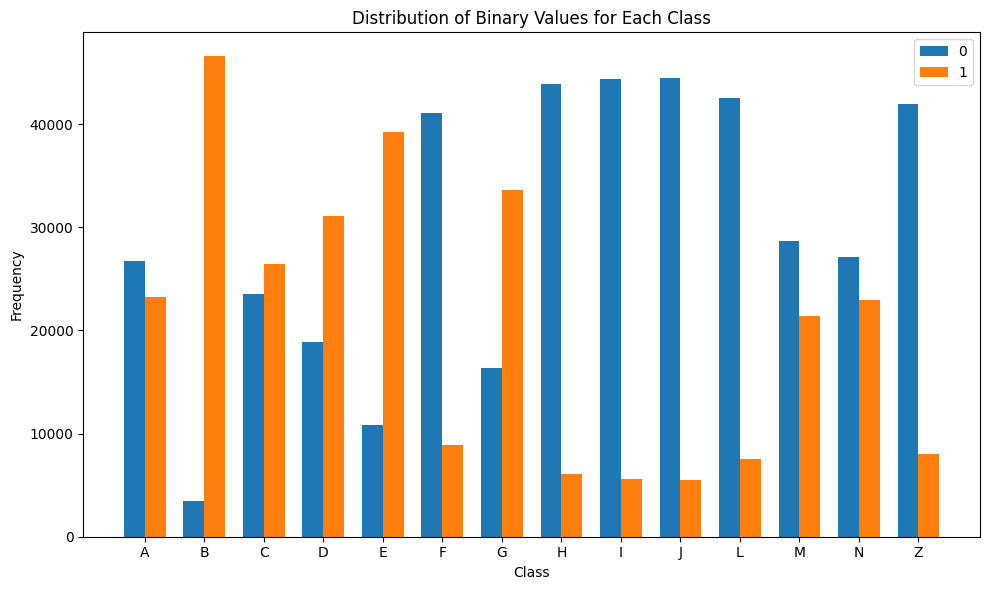

In [19]:
class_frequencies = []

# Define the class labels
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']

# Iterate over each class
for i in range(14):
    class_data = [row[i] for row in df['target']]
    frequency_0 = class_data.count(0)
    frequency_1 = class_data.count(1)
    class_frequencies.append((frequency_0, frequency_1))

# Plot the frequencies for each class
plt.figure(figsize=(10, 6))  
bar_width = 0.35
index = range(len(class_frequencies))
plt.bar(index, [freq[0] for freq in class_frequencies], bar_width, label='0')
plt.bar([i + bar_width for i in index], [freq[1] for freq in class_frequencies], bar_width, label='1')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Binary Values for Each Class')
plt.xticks([i + bar_width / 2 for i in index], class_labels)
plt.legend()
plt.tight_layout()
plt.show()


# **Text Tokenizer**

Wrapping the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

In [20]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe[['Title', 'abstractText', 'target']]
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        title, abstract, target = self.data.iloc[index]
        full_text = title + ' ' + abstract

        inputs = self.tokenizer.encode_plus(
            full_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'ids': inputs['input_ids'].flatten(),
            'mask': inputs['attention_mask'].flatten(),
            'token_type_ids':inputs['token_type_ids'].flatten(),
            'targets': torch.tensor(target, dtype=torch.float)
        }


In [21]:
dict = {}
for title in df['Title']:
  title_array = title.split()
  length_title = len(title_array)
  if(length_title not in dict):
    dict[length_title] = 1
  else:
    dict[length_title]+=1
print(dict)

{14: 3950, 21: 1055, 12: 4412, 11: 4146, 8: 2564, 20: 1377, 22: 854, 10: 3780, 13: 4329, 7: 1897, 18: 2181, 9: 3141, 16: 3136, 17: 2637, 15: 3562, 25: 312, 5: 854, 3: 164, 24: 431, 6: 1310, 19: 1864, 23: 675, 2: 98, 4: 383, 28: 131, 34: 19, 26: 204, 27: 184, 46: 2, 1: 30, 38: 9, 29: 101, 33: 21, 32: 37, 35: 20, 36: 4, 31: 44, 30: 62, 42: 3, 37: 6, 39: 3, 47: 1, 57: 1, 40: 2, 41: 1, 43: 1}


# **Loading Tokenizer**

In [22]:
max_length = 512
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# **Dataset**

Creating the dataset and dataloader for the neural network

In [23]:
train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=0)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


training_set = CustomDataset(train_dataset, tokenizer, max_length)
testing_set = CustomDataset(test_dataset, tokenizer, max_length)

# **Histogram Plot With Truncation**

Processing rows: 100%|██████████| 49998/49998 [08:00<00:00, 104.08it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


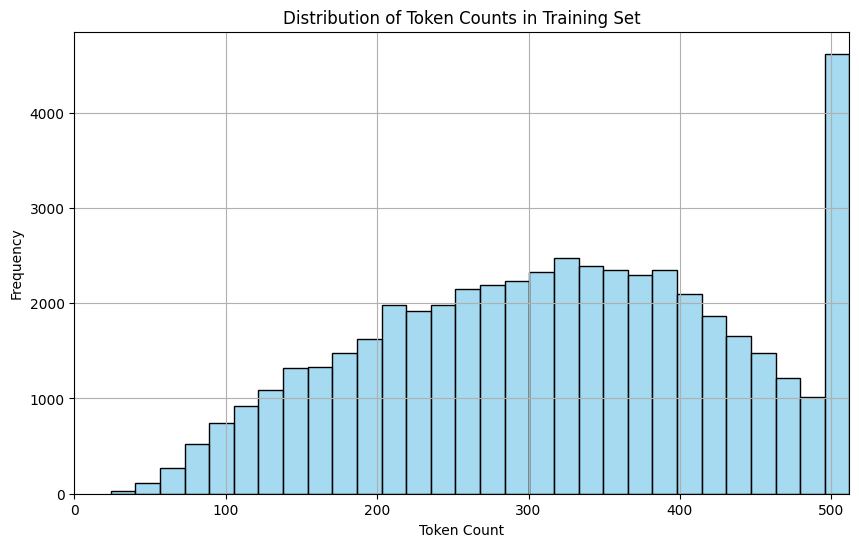

In [15]:
token_counts = []

for _, row in tqdm(df.iterrows(), desc='Processing rows', total=len(df)):
    # Concatenate the title and abstract text
    text = row['Title'] + row['abstractText']
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)


# Plot the histogram of token counts using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.histplot(token_counts, bins=30, kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Token Counts in Training Set')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.grid(True)  # Add grid lines
plt.xlim([0, 512])  # Limit x-axis range to avoid outliers
plt.show()


# **Histogram Plot With No Truncation**

Processing rows: 100%|██████████| 49998/49998 [06:06<00:00, 136.44it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


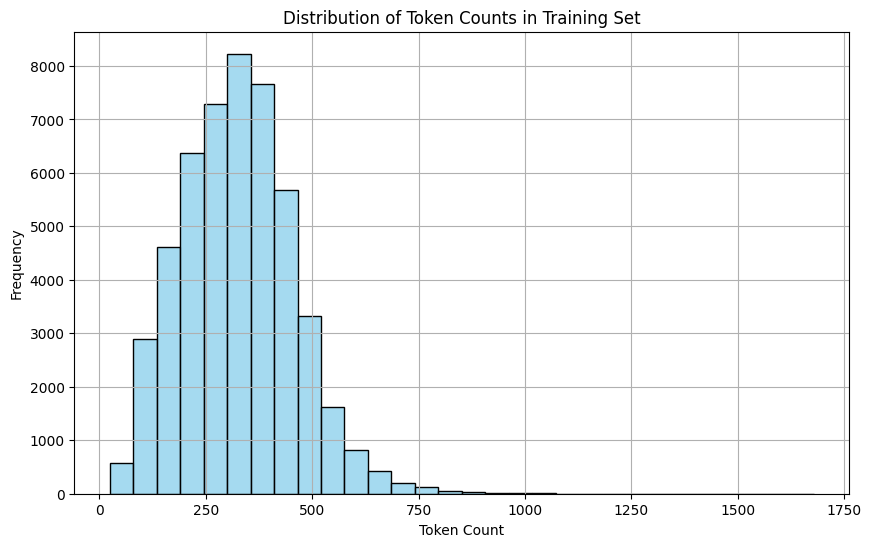

In [18]:
token_counts_no_trunc = []

for _, row in tqdm(df.iterrows(), desc='Processing rows', total=len(df)):
    # Concatenate the title and abstract text
    text = row['Title'] + row['abstractText']
    token_count = len(tokenizer.encode(text))
    token_counts_no_trunc.append(token_count)


# Plot the histogram of token counts using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.histplot(token_counts_no_trunc, bins=30, kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Token Counts in Training Set')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.grid(True)  # Add grid lines
# plt.xlim([0, 512])  # Limit x-axis range to avoid outliers
plt.show()


In [22]:
dict_total_tokens = {}
maxi = max(token_counts_no_trunc)
count = 0
for val in token_counts_no_trunc:
    if(val>512):
        count+=1
    if(val not in dict_total_tokens ):
        dict_total_tokens[val] = 1
    else:
        dict_total_tokens[val]+=1
dict_total_tokens
print(count)
print(maxi)

3696
1680


# **MODEL 1**

# **Basic Hyperparameters**

In [24]:
train_batch_size = 10
valid_batch_size = 4
epochs = 1
learning_rate = 1e-05

# **Dataloader**

In [25]:
training_loader = DataLoader(training_set, batch_size = train_batch_size,shuffle = True)

In [26]:
sample_batch = next(iter(DataLoader(training_set, batch_size=8, num_workers=2)))
sample_batch["ids"].shape, sample_batch["mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [27]:
ids = sample_batch['ids']
mask = sample_batch['mask']
token_type_ids = sample_batch['token_type_ids']

# Print the tensors
print("Ids:")
print(ids)
print("Mask:")
print(mask)
print("Token Type IDs:")
print(token_type_ids)

Ids:
tensor([[  101,  4654,  4747,  ...,     0,     0,     0],
        [  101,  1996, 26536,  ...,     0,     0,     0],
        [  101,  3746,  1011,  ...,     0,     0,     0],
        ...,
        [  101, 23586,  1997,  ...,     0,     0,     0],
        [  101, 16480,  2571,  ...,     0,     0,     0],
        [  101, 27520,  2007,  ...,     0,     0,     0]])
Mask:
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Token Type IDs:
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [28]:
bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [29]:
output = bert_model(sample_batch["ids"], sample_batch["mask"],sample_batch['token_type_ids'])
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.6433, -0.1715, -0.1659,  ..., -0.0817,  0.2727,  0.4357],
         [-0.1495,  0.0208, -0.0662,  ...,  0.0759,  0.7400, -0.0634],
         [-1.2365,  0.4474,  0.3618,  ..., -0.0359, -0.3891,  0.5474],
         ...,
         [ 0.3596, -0.2680,  0.2088,  ..., -0.4912, -0.2285, -0.1550],
         [-0.0284,  0.0460,  0.0063,  ..., -0.1551, -0.0746, -0.1423],
         [-0.1890, -0.0663,  0.4232,  ..., -0.2905, -0.0044,  0.0351]],

        [[-0.6607, -0.4721, -0.1309,  ..., -0.4214,  0.1744,  0.1726],
         [-0.3486, -0.1079, -0.8868,  ...,  0.6708,  0.9485, -0.4249],
         [-1.0101,  0.0755,  0.6168,  ...,  0.2002, -0.1704,  0.3915],
         ...,
         [ 0.2112,  0.2366,  0.2973,  ..., -0.1287, -0.1759,  0.1775],
         [ 0.3457,  0.0562,  0.2133,  ..., -0.1468, -0.1648,  0.1137],
         [ 0.2611, -0.0774,  0.4387,  ..., -0.0619, -0.1701, -0.1534]],

        [[-0.9585, -0.5679,  0.0322,  ..., -0.0337,  

In [30]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

# **Fine Tuned Model Architecture**

In [31]:
class CustomBERTClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(CustomBERTClass, self).__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.dropout1 = torch.nn.Dropout(0.3)
        self.fc1 = torch.nn.Linear(768, 512)  # First linear layer
        self.dropout2 = torch.nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(512, num_classes)  # Second linear layer for classification

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=False)
        x = self.dropout1(pooled_output)
        x = torch.relu(self.fc1(x))  # Applying ReLU activation to the output of the first FC layer
        x = self.dropout2(x)
        output = self.fc2(x)
        return output

# Instantiate the model
num_classes = 14  # Number of output classes
model_1 = CustomBERTClass(num_classes)
model_1.to(device)


CustomBERTClass(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

# **Loss Function**

In [32]:
def loss_function(outputs, targets,value):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(outputs, targets)
    return loss

# **Optimizer**

In [33]:
def optimizer_function(learning_rate,model,value):
    if(value==1):
        return torch.optim.Adam(params =  model.parameters(), lr=learning_rate)
    if(value==2):
        return torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [34]:
optimizer = optimizer_function(learning_rate,model_1,1)  #Adam

# **Training**

In [35]:
training_loss = []

In [50]:
def train_model(num_epochs,model,training_loader,value):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0  # Reset total loss for each epoch

        # Wrap the training_loader with tqdm to create a progress bar
        with tqdm(training_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as t:
            for batch_idx, data in enumerate(t):
                input_ids = data['ids'].to(device)
                attention_mask = data['mask'].to(device)
                token_type_ids = data['token_type_ids'].to(device)
                targets = data['targets'].to(device)

                # Forward pass
                outputs = model(input_ids, attention_mask, token_type_ids)
                # Calculate loss
                loss = loss_function(outputs, targets,value)
                total_loss += loss.item()  # Accumulate the loss

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if(batch_idx % 50==0):
                    training_loss.append(loss.item())
                # Update the progress bar with the current loss
                t.set_postfix(loss=loss.item())

        # Save checkpoint at the end of each epoch
        save_checkpoint(model, optimizer, epoch,value)

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(training_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

def save_checkpoint(num, model, optimizer, epoch, save_dir='./'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer,
    }
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)
    # Save the checkpoint file
    checkpoint_path = os.path.join(save_dir, f'model_{num}_checkpoint_epoch{epoch}.pt')
    torch.save(checkpoint, checkpoint_path)


In [28]:
train_model(epochs,model_1,training_loader,1)

Epoch 1/1: 100%|██████████| 4000/4000 [43:10<00:00,  1.54batch/s, loss=0.288]


Epoch 1/1, Average Loss: 0.3658


In [37]:
def plot_training_loss(training_loss):
    plt.plot(training_loss, label='Training Loss')
    plt.xlabel('Batch Index')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Batch Index')
    plt.legend()
    plt.show()

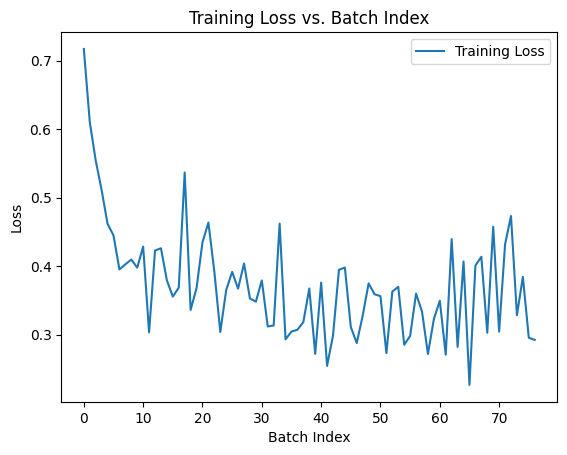

In [46]:
training_loss_trimmed = training_loss[:-8] 
plot_training_loss(training_loss_trimmed)

# **MODEL 2**

In [38]:
# Instantiate the model
num_classes = 14  # Number of output classes
model_2 = CustomBERTClass(num_classes)
model_2.to(device)

CustomBERTClass(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [40]:
train_batch_size_2 = 12
valid_batch_size_2 = 4
epochs_2 = 1
learning_rate_2 = 1e-04
training_loader_2 = DataLoader(training_set, batch_size = train_batch_size_2,shuffle = True)
optimizer = optimizer_function(learning_rate_2,model_2,2) #SGD with Momentum

In [41]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_cached())

882396160
966787072


/opt/conda/lib/python3.10/site-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [42]:
training_loss.clear()
train_model(epochs_2,model_2,training_loader_2,2)

Epoch 1/1: 100%|██████████| 3334/3334 [41:47<00:00,  1.33batch/s, loss=0.694]


AttributeError: 'int' object has no attribute 'state_dict'

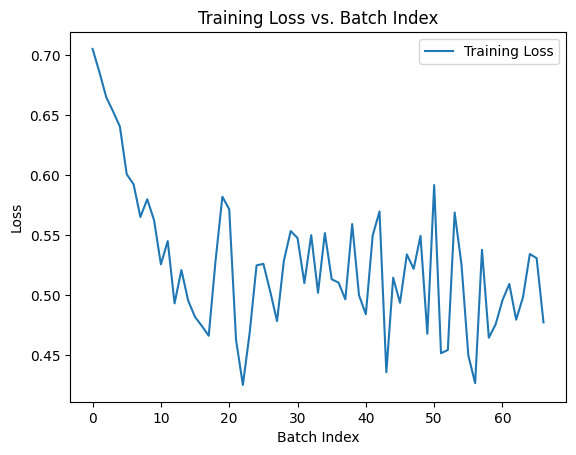

In [47]:
plot_training_loss(training_loss)

# **MODEL 3**

In [ ]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
num_classes = 14
model = CustomXLNetClass(num_classes)

In [ ]:
training_set = CustomDataset(train_dataset, tokenizer, max_length)
training_loader = DataLoader(training_set, batch_size = train_batch_size,shuffle = True)

In [ ]:
class CustomXLNetClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(CustomXLNetClass, self).__init__()
        self.xlnet = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=num_classes)
        self.dropout1 = torch.nn.Dropout(0.3)
        self.fc1 = torch.nn.Linear(768, 512)  # First linear layer
        self.dropout2 = torch.nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(512, num_classes)  # Second linear layer for classification

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.xlnet(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=False)
        x = self.dropout1(pooled_output)
        x = torch.relu(self.fc1(x))  # Applying ReLU activation to the output of the first FC layer
        x = self.dropout2(x)
        output = self.fc2(x)
        return output

# Instantiate the model
num_classes = 14  # Number of output classes
model_3 = CustomXLNetClass(num_classes)
model_3.to(device)


In [ ]:
train_model(epochs_2,model_3,training_loader_2,3)